###IMPORTING DATASET

In [ ]:
##Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Importing the data
data=pd.read_csv('bank-additional-full.csv',delimiter=';')

In [ ]:
data['y'].unique()

array(['no', 'yes'], dtype=object)

In [ ]:
data.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
data.pdays.unique()

array([999,   6,   4,   3,   5,   1,   0,  10,   7,   8,   9,  11,   2,
        12,  13])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36959 entries, 0 to 36958
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             36959 non-null  int64  
 1   job             36959 non-null  object 
 2   marital         36959 non-null  object 
 3   education       36959 non-null  object 
 4   default         36959 non-null  object 
 5   housing         36959 non-null  object 
 6   loan            36959 non-null  object 
 7   contact         36959 non-null  object 
 8   month           36959 non-null  object 
 9   day_of_week     36959 non-null  object 
 10  duration        36959 non-null  int64  
 11  campaign        36959 non-null  int64  
 12  pdays           36959 non-null  int64  
 13  previous        36959 non-null  int64  
 14  poutcome        36959 non-null  object 
 15  emp.var.rate    36959 non-null  float64
 16  cons.price.idx  36959 non-null  float64
 17  cons.conf.idx   36959 non-null 

**OUTLINE**

*Preprocesing

*Class Imabalance Treatment

*Model Pipeline

*Dimensionality Reduction

*Hyperparameter Tuning(Grid Search)

*Model Building

###DATA PROCESSING

Some columns like job,education,marital etc contain string values hence we need to map them into features.We'll use one-hot encoding for these columns and label encoding for the target variable.One-hot encoding is useful when the categorical features are not ordinal (non-hierarchical).
We'll use the Standard Scaler for scaling our data.The main idea why this is done is that some variables are often measured at different scales and would not contribute equally to model fitting and this may lead the trained model to create some bias. Hence, in dealing with it is usually important to normalize.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
def preprocess(data):


  data['education'] = np.where((data['education']=='basic.4y')|(data['education']=='basic.6y')|(data['education']=='basic.9y'),'primary' , data['education'])
  data['education'] = np.where((data['education']=='high.school'),'secondary' , data['education'])
  data['education'] = np.where((data['education']=='university.degree')|(data['education']=='professional.course'),'tertiary' , data['education'])
  data['education'] = np.where((data['education']=='unknown')|(data['education']=='illiterate'),'unknown' , data['education'])


  # Map padys=-1 into a large value (10000 is used) to indicate that it is so far in the past that it has no effect
  data['pdays']=np.where(data['pdays']==999,0,data['pdays'])

  ##Target variable
  
  labelencoder=LabelEncoder()
  data['y']=labelencoder.fit_transform(data['y'])
  
  categorical_features = data.select_dtypes(include=['object']).columns
  numerical_features = data.select_dtypes(include=['float64', 'int64']).drop(['y'],axis=1).columns  
  
  for col in categorical_features: 
    #label_encoder = LabelEncoder()
    #enc=OneHotEncoder(sparse=True)
    #data[col]=enc.fit_transform(label_encoder.fit_transform(data[col].values.reshape(-1,1)).ravel())

    # use pd.concat to join the new columns with your original dataframe
    data = pd.concat([data,pd.get_dummies(data[col], prefix=col)],axis=1)
    # now drop the original 'country' column (you don't need it anymore)
    data.drop([col],axis=1, inplace=True)

  
  for col in numerical_features:
    SC=StandardScaler()
    data[col]=SC.fit_transform(data[col].values.reshape(-1,1))

  return data

In [ ]:
data=preprocess(data)

In [ ]:
data.head(2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,1.533034,0.010471,-0.565922,-0.164012,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,1.628993,-0.421501,-0.565922,-0.164012,-0.349494,0.648092,0.722722,0.886447,0.71246,0.33168,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0


### CLASS IMBALANCE

* From our analysis,we found out that there was class imabalance in out target variable,which could produce misleading results.
* This will make the classsifier biased (mostly predicting the most common class).

* A highly adopted technique to deal with highlt unbalnced datasets is resmpling.It consists of removing samples from the majority class(under-sampling) and/ or adding more examples from the minority class(over-sampling).

* The simplest implementation of over-sampling is to duplicate random records from the minority class, which can cause overfitting. In under-sampling, the simplest technique involves removing random records from the majority class, which can cause loss of information.

* In order to deal with this, we can use the **imblearn** module from sklearn ie In over-sampling, instead of creating exact copies of the minority class records, we can introduce small variations into those copies, creating more diverse synthetic samples.
 
*  Here we will use imblearn’s SMOTE or Synthetic Minority Oversampling Technique. SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.

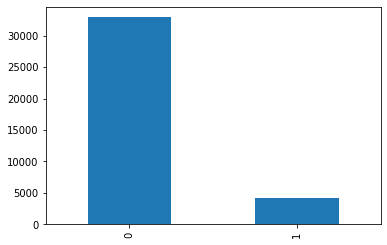

In [ ]:
# observe that data has not been balanced
pd.Series(y_train).value_counts().plot.bar()

In [ ]:
X=data.drop(['y'],axis=1)
#y=data.iloc[:,-1]
y=data['y']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(ratio='minority')
X_train, y_train = smote.fit_sample(X_train, y_train)



/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#from imblearn.over_sampling import SMOTENC
#smote_nc = SMOTENC(categorical_features=[1, 2,3,4,5,6,7,8,9,14,], random_state=0)
#X_resampled, y_resampled = smote_nc.fit_resample(X, y)

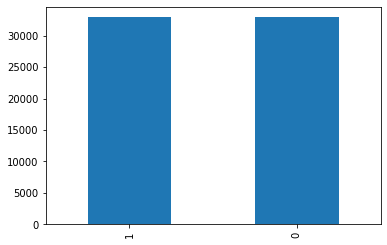

In [ ]:
# observe that data has been balanced
pd.Series(y_train).value_counts().plot.bar()

In [ ]:
X_train.shape

(65792, 59)

In [ ]:
#X_resampled=pd.DataFrame(X_resampled)
#X_resampled.columns=list(data.drop(['y'],axis=1).columns)
#X_resampled.shape

(73096, 20)

###Explore TSNE, autoencoders, and PCA dimensionality reductions techniques.

**Dimensionality Reduction Using PCA**
* Principal Componenet Analysis works by identifying the hyperplane which lies closest to the data and then projects the data on that hyperplane while retaining most of the variation in the data set.
 * Principal Components-this is the axis that explains the maximum amount of variance in the training set.
 The axis orthogonal to this axis is called the second principak component.As we go for higher dimensions,PCA would find a third component orthogoanl to the other two componentts and so on,for visulaization purposes,we always stick to 2 or maximum 3 principal components.
 * It is very important to choose the right hyperplane so tht when the data is projected onto it,the maximum amount of info. about how the original data is distributed is shown.

In [ ]:
from sklearn.decomposition import PCA
#Define the transform
pca=PCA()
#Prepare transform on dataset
pca.fit(X_train)

#apply transform to dataset
transofmed=pca.transform(X_train)

In [ ]:

pca.explained_variance_ratio_

array([2.91745113e-01, 1.32758763e-01, 8.90431719e-02, 7.74889121e-02,
       6.43018355e-02, 4.78434655e-02, 3.60792620e-02, 3.28095878e-02,
       2.41751220e-02, 2.23108882e-02, 1.56779826e-02, 1.49345138e-02,
       1.32404756e-02, 1.13298050e-02, 1.04729389e-02, 9.92621933e-03,
       9.46188689e-03, 9.24074692e-03, 9.03688918e-03, 8.67003563e-03,
       8.51570886e-03, 6.32897014e-03, 5.56849427e-03, 4.87263624e-03,
       4.62780538e-03, 4.28245786e-03, 4.04484770e-03, 3.86404338e-03,
       2.91276564e-03, 2.70723915e-03, 2.55982151e-03, 2.44372098e-03,
       2.21580006e-03, 1.95182669e-03, 1.86004791e-03, 1.68706102e-03,
       1.62872313e-03, 1.37686770e-03, 1.26082121e-03, 1.22453250e-03,
       1.18578111e-03, 1.01272523e-03, 4.59205366e-04, 3.34661225e-04,
       2.90116920e-04, 1.30730103e-04, 1.01538488e-04, 3.43462656e-06,
       3.62683584e-31, 5.75365785e-32, 1.49411905e-33, 1.49411905e-33,
       1.49411905e-33, 1.49411905e-33, 1.49411905e-33, 1.49411905e-33,
      

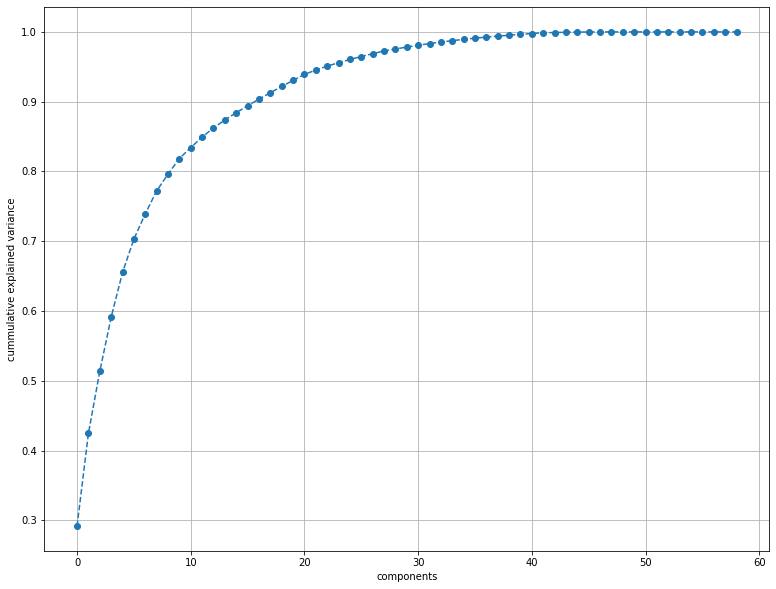

In [ ]:

plt.figure(figsize = (13,10))
plt.plot(range(59), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.xlabel('components')
plt.ylabel('cummulative explained variance')
plt.grid(True)

PCA looks for properties that show as much variation across classes as possible to build the principal component space(assumes that features that present high variance are more likely to have a good split between classes.).The algorithm use the concepts of variance matrix, covariance matrix, eigenvector and eigenvalues pairs to perform PCA, providing a set of eigenvectors and its respectively eigenvalues as a result..When choosing the number of components, the number cutting at least 80% of the cumm explained variance is considered. 




When choosing the number of components, the number cutting at least 80% of the cumm explained variance is considered. n = 10

In [ ]:
pca=PCA(n_components=10)
pca.fit(X_train)
pca_scores=pca.transform(X_train)
X_train=pd.DataFrame(pca_scores)
X_train.head(4)

,0,1,2,3,4,5,6,7,8,9
0,-2.372271,0.861437,-0.315866,-1.565197,-0.542742,0.026771,0.412125,0.576085,1.044237,-0.211978
1,-2.271509,0.804844,-0.228315,-1.141149,-0.235128,0.147662,0.620648,0.658177,-0.198981,0.601682
2,-2.214501,0.857599,-1.189875,-0.898933,0.181179,0.048682,-0.086192,-0.355703,-0.368442,-1.072517
3,-1.987787,0.552753,0.708862,0.751093,-1.614725,-0.256155,0.706634,-0.616352,-0.528662,-0.273660


###PIPELINE

In [ ]:
X_resampled.shape

(65770, 20)

In [ ]:

##SKLEARN MODEL PIPELINE


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

##Function to preprocess the data

num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                    #('drop_attributes', AttributeDeleter()),
                                    ('std_scaler', StandardScaler())
                            ])
categorical_pipeline=Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

categorical_features = data.select_dtypes(include=['object']).columns
numerical_features = data.select_dtypes(include=['float64', 'int64']).drop(['y'],axis=1).columns

full_pipeline = ColumnTransformer(
        transformers=[('num', num_pipeline, numerical_features),
                     ('cat', categorical_pipeline, categorical_features)])

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Making pipelines

categorical_features = data.select_dtypes(include=['object']).columns
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns

num_pipeline = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                    #('drop_attributes', AttributeDeleter()),
                                    ('std_scaler', StandardScaler())
                            ])
categorical_pipeline=Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("numerical_pipeline", num_pipeline,numerical_features),
        ("categorical_pipeline", categorical_pipeline,categorical_features),
    ])

In [ ]:
X_train = preprocess_pipeline.fit_transform(train_data)

In [ ]:
features=full_pipeline.fit(X_train,y_train)

In [ ]:
features

ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('num',
                                 Pipeline(memory=None,
                                          steps=[('imputer',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='median',
                                                                verbose=0)),
                                                 ('std_scaler',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                       

##MODEL SELECTION AND HYPERPARAMETER TUNING

**CROSS VALIDATION**
* Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

* The general procedure is as follows:



1.   Shuffle the dataset randomly.
2.   Split the dataset into k groups
3.   For each unique group:
   
   Take the group as a hold out or test data set
Take the remaining groups as a training data set
Fit a model on the training set and evaluate it on the test set
Retain the evaluation score and discard the model.
4. Summarize the skill of the model using the sample of model evaluation scores



*This approach involves randomly dividing the set of observations into k groups, or folds, of approximately equal size. The first fold is treated as a validation set, and the method is fit on the remaining k − 1 folds.*

*Typically,one performs k-fold cross-validation using k = 5 or k = 10, as these values have been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance.*

### Using Stratified K-fold

* Stratified: The splitting of data into folds may be governed by criteria such as ensuring that each fold has the same proportion of observations with a given categorical value, such as the class outcome value.
* Repeated: This is where the k-fold cross-validation procedure is repeated n times, where importantly, the data sample is shuffled prior to each repetition, which results in a different split of the sample.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

classifiers = [
    LogisticRegression(),
    SVC(kernel="rbf", C=0.025, probability=True),
    XGBClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[('pca',PCA(n_components=10)),
                      ('classifier', classifier)])
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    n_scores = cross_val_score(pipe, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    #print("model score: %.3f" % pipe.score(X_test, y_test))

Accuracy: 0.906 (0.003)


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy: 0.901 (0.002)
Accuracy: 0.910 (0.003)
Accuracy: 0.884 (0.005)
Accuracy: 0.909 (0.004)


From above we see the accuracy for the different models using stratified k-fold=10:
 * Logistic Regression-0.906
 * Support Vector Classifier-0.901
 * XGB Classifier -0.910
 * Decision Tree Classifier - 0.884
 * Rndom forest Classifer - 0.909

 The XBGClassifier and RandomForestClassifier perfomed better respectively.

### Using K-fold =10

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

classifiers = [
    LogisticRegression(),
    SVC(kernel="rbf", C=0.025, probability=True),
    XGBClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    ]
for classifier in classifiers:
    pipe = Pipeline(steps=[('pca',PCA(n_components=10)),
                      ('classifier', classifier)])
    cv = KFold(n_splits=10, shuffle=True, random_state=0)
    n_scores = cross_val_score(pipe, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
    #print("model score: %.3f" % pipe.score(X_test, y_test))

Accuracy: 0.906 (0.005)


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Accuracy: 0.900 (0.003)
Accuracy: 0.911 (0.006)
Accuracy: 0.883 (0.003)
Accuracy: 0.910 (0.006)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [ ]:
logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train)
logpred = logmodel.predict(X_test)


print(confusion_matrix(y_test, logpred))
print(round(accuracy_score(y_test, logpred),2)*100)
LOGCV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[3161  519]
 [  32  407]]
87.0


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
from sklearn.svm import SVC
svc= SVC(kernel = 'sigmoid')
svc.fit(X_train, y_train)
svcpred = svc.predict(X_test)
print(confusion_matrix(y_test, svcpred))
print(round(accuracy_score(y_test, svcpred),2)*100)
SVCCV = (cross_val_score(svc, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
SVCCV

[[2759  921]
 [ 104  335]]
75.0


0.7559175251652929

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion='gini') #criterion = entopy, gini
dtree.fit(X_train, y_train)
dtreepred = dtree.predict(X_test)

print(confusion_matrix(y_test, dtreepred))
print(round(accuracy_score(y_test, dtreepred),2)*100)
DTREECV = (cross_val_score(dtree, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[3375  277]
 [ 204  263]]
88.0


In [67]:
from sklearn.ensemble.forest import RandomForestClassifier
randomtree = RandomForestClassifier(criterion='gini') #criterion = entopy, gini
randomtree.fit(X_train, y_train)
randomtreepred = randomtree.predict(X_test)

print(confusion_matrix(y_test, randomtreepred))
print(round(accuracy_score(y_test,randomtreepred),2)*100)
RFCCV = (cross_val_score(randomtree, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())
RFCCV

[[3496  156]
 [ 200  267]]
91.0


0.959204755298128

In [68]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgbprd = xgb.predict(X_test)

print(confusion_matrix(y_test, xgbprd ))
print(round(accuracy_score(y_test, xgbprd),2)*100)
XGB = (cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10).mean())
XGB

ValueError: ignored

In [69]:
models = pd.DataFrame({
                'Models': ['Random Forest Classifier', 'Decision Tree Classifier', 'Support Vector Machine'
                           , 'Logistic Model'],
                'Score':  [RFCCV, DTREECV, SVCCV,  LOGCV]})

models.sort_values(by='Score', ascending=False)

,Models,Score
0,Random Forest Classifier,0.959205
1,Decision Tree Classifier,0.959007
3,Logistic Model,0.880994
2,Support Vector Machine,0.755918


ValueError: ignored

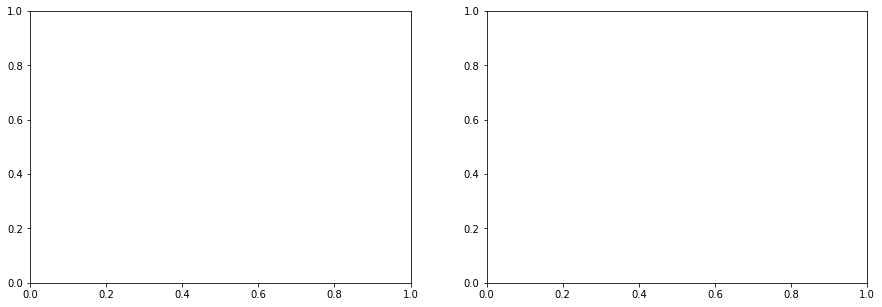

In [70]:
from sklearn import metrics
fig, (ax, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
probs = xgb.predict_proba(X_test)
preds = probs[:,1]
fprxgb, tprxgb, thresholdxgb = metrics.roc_curve(y_test, preds)
roc_aucxgb = metrics.auc(fprxgb, tprxgb)

ax.plot(fprxgb, tprxgb, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
ax.plot([0, 1], [0, 1],'r--')
ax.set_title('Receiver Operating Characteristic XGBOOST ',fontsize=10)
ax.set_ylabel('True Positive Rate',fontsize=20)
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.legend(loc = 'lower right', prop={'size': 16})

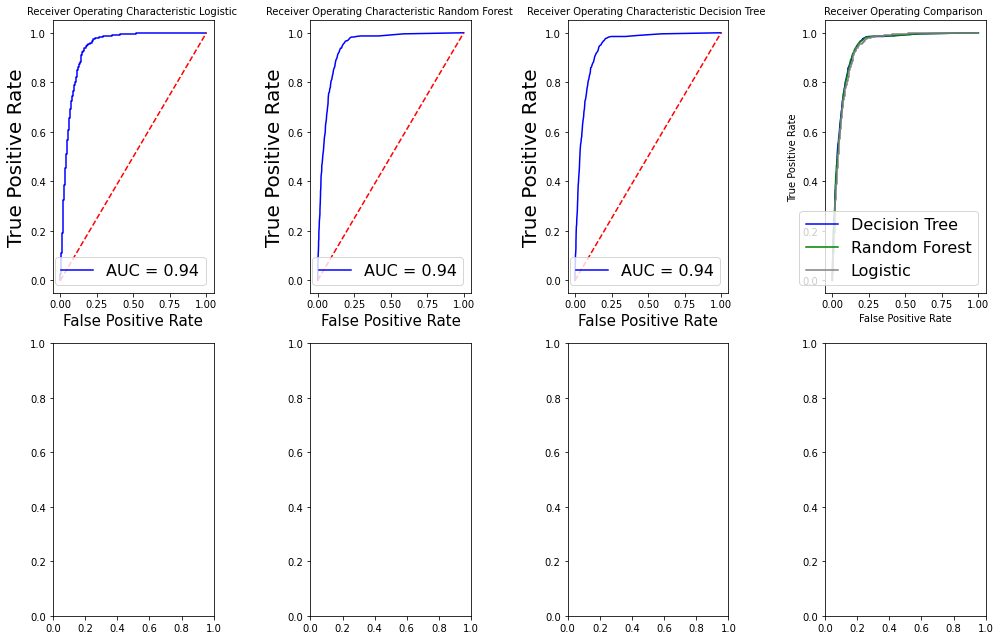

In [83]:
fig, ax_arr = plt.subplots(nrows = 2, ncols = 4, figsize = (14,9))

#LOGMODEL
probs = logmodel.predict_proba(X_test)
preds = probs[:,1]
fprlog, tprlog, thresholdlog = metrics.roc_curve(y_test, preds)
roc_auclog = metrics.auc(fprlog, tprlog)

ax_arr[0,0].plot(fprlog, tprlog, 'b', label = 'AUC = %0.2f' % roc_auclog)
ax_arr[0,0].plot([0, 1], [0, 1],'r--')
ax_arr[0,0].set_title('Receiver Operating Characteristic Logistic ',fontsize=10)
ax_arr[0,0].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,0].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,0].legend(loc = 'lower right', prop={'size': 16})

#RANDOM FOREST --------------------
probs = randomtree.predict_proba(X_test)
preds = probs[:,1]
fprrfc, tprrfc, thresholdrfc = metrics.roc_curve(y_test, preds)
roc_aucrfc = metrics.auc(fprrfc, tprrfc)

ax_arr[0,1].plot(fprrfc, tprrfc, 'b', label = 'AUC = %0.2f' % roc_aucrfc)
ax_arr[0,1].plot([0, 1], [0, 1],'r--')
ax_arr[0,1].set_title('Receiver Operating Characteristic Random Forest ',fontsize=10)
ax_arr[0,1].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,1].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,1].legend(loc = 'lower right', prop={'size': 16})



#DECISION TREE ---------------------
probs = dtree.predict_proba(X_test)
preds = probs[:,1]
fprdtree, tprdtree, thresholddtree = metrics.roc_curve(y_test, preds)
roc_aucdtree = metrics.auc(fprdtree, tprdtree)

ax_arr[0,2].plot(fprdtree, tprdtree, 'b', label = 'AUC = %0.2f' % roc_aucdtree)
ax_arr[0,2].plot([0, 1], [0, 1],'r--')
ax_arr[0,2].set_title('Receiver Operating Characteristic Decision Tree ',fontsize=10)
ax_arr[0,2].set_ylabel('True Positive Rate',fontsize=20)
ax_arr[0,2].set_xlabel('False Positive Rate',fontsize=15)
ax_arr[0,2].legend(loc = 'lower right', prop={'size': 16})



#ALL PLOTS ----------------------------------

ax_arr[0,3].plot(fprdtree, tprdtree, 'b', label = 'Decision Tree', color='blue')
ax_arr[0,3].plot(fprrfc, tprrfc, 'b', label = 'Random Forest', color='green')
ax_arr[0,3].plot(fprlog, tprlog, 'b', label = 'Logistic', color='grey')
ax_arr[0,3].set_title('Receiver Operating Comparison ',fontsize=10)
ax_arr[0,3].set_ylabel('True Positive Rate',fontsize=10)
ax_arr[0,3].set_xlabel('False Positive Rate',fontsize=10)
ax_arr[0,3].legend(loc = 'lower right', prop={'size': 16})

plt.subplots_adjust(wspace=0.2)
plt.tight_layout() 

###MODEL ACCURACY

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

grid_param = {
    'n_estimators': [100, 200],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False]
}

rfc = RandomForestClassifier()#criterion = entopy,gini

gd_srf = GridSearchCV(estimator=rfc,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)


gd_srf.fit(X_train, y_train)
gd_srfpred = rfc.predict(X_test)

print(confusion_matrix(y_test, gd_srfpred ))
print(round(accuracy_score(y_test, gd_srfpred),2)*100)
#RFCCV = (cross_val_score(gd_srf, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

NotFittedError: ignored